<a href="https://colab.research.google.com/github/haseeb-505/learning_pytorch_campusx/blob/main/hyperparameter_tuning_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# !pip install optuna

In [16]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt

In [17]:
# set random seed for reproducibility
torch.manual_seed(42)

In [18]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


## Data Loading

In [19]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

# test data loading
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [20]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

### plotting some images

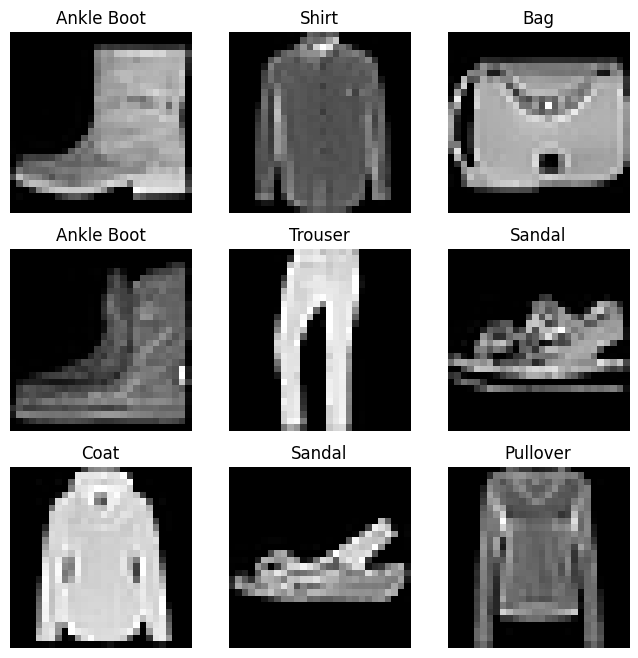

In [21]:
fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(labels_map[label])
    plt.axis('off')
plt.show()

In [22]:
# data size
print(f'train data size: {len(train_data)}')
print(f'test data size: {len(test_data)}')

train data size: 60000
test data size: 10000


In [23]:
# Get shape of the first sample
print(type(train_data[0]))
first_sample, first_label = train_data[0]  # Fetch first data point
print(first_sample.shape)
print((first_sample.flatten().shape)[0])

<class 'tuple'>
torch.Size([1, 28, 28])
784


### Model Design

In [24]:
# model design
class MyNN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer,dropout_rate):
    super().__init__()

    layers = []
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      # batch normalization
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      # activation function
      layers.append(nn.ReLU())
      # dropouts
      layers.append(nn.Dropout(dropout_rate))
      # update input dim for next iteration
      input_dim = neurons_per_layer

    layers.append(nn.Linear(input_dim, output_dim))
    self.stack = nn.Sequential(*layers)

  def forward(self, x):
    return self.stack(x)

### Objective Function

In [25]:
def objective(trial):

  # extract hyperparameter values for next trial from the search sapce
  num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
  neurons_per_layer = trial.suggest_int('neurons_per_layer', 8, 128, step=8)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  epochs = trial.suggest_int('num_epochs', 10, 50)
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)

  # dataloader
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

  # model initialization
  input_dim = (first_sample.flatten().shape)[0]
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)



  # loss function and optimizer selection
  criterion = nn.CrossEntropyLoss()

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  # training loop
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_dataloader):
      data, target = data.to(device), target.to(device)
      # reshaping data tensor to desired form
      data = data.view(data.size(0), -1)
      # setting optimizer gradient to zero to avoid the effect of the case where it can carry some previous value
      optimizer.zero_grad()
      # forward pass
      output = model(data)
      # loss fucntion
      loss = criterion(output, target)
      # backpropagation
      loss.backward()
      # optimizer step
      optimizer.step()
  # evaluation
  model.eval()
  test_loss = 0
  test_correct = 0
  accuracy_list = []

  with torch.no_grad():
    for data, target in test_dataloader:
      data, target = data.to(device), target.to(device)
      data = data.view(data.size(0), -1)
      y_pred = model(data)
      # Get the predicted class index for each sample
      _, predicted_labels = torch.max(y_pred, 1)

      # batch_accuracy compare predicted labels with actual labels
      batch_accuracy = (predicted_labels == target).float().mean()
      accuracy_list.append(batch_accuracy.item())

  accuracy = torch.tensor(accuracy_list).mean()
  print(f"Accuracy: {accuracy}")

  return accuracy

### Study Creation

In [26]:
study = optuna.create_study(direction='maximize')


[I 2025-02-20 16:38:11,932] A new study created in memory with name: no-name-eebffe9f-9442-47f3-a85d-d4c1d5fe4046


In [27]:
# run study
study.optimize(objective, n_trials=10)

[I 2025-02-20 16:41:01,278] Trial 0 finished with value: 0.8258504867553711 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 40, 'learning_rate': 0.0004929943482455661, 'num_epochs': 26, 'dropout_rate': 0.5, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.004216243994558532}. Best is trial 0 with value: 0.8258504867553711.


Accuracy: 0.8258504867553711


[I 2025-02-20 16:44:50,491] Trial 1 finished with value: 0.8179000020027161 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 48, 'learning_rate': 0.0025386482434245064, 'num_epochs': 19, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.002776586391718291}. Best is trial 0 with value: 0.8258504867553711.


Accuracy: 0.8179000020027161


[I 2025-02-20 16:49:48,524] Trial 2 finished with value: 0.8716054558753967 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 72, 'learning_rate': 0.0026187881342771093, 'num_epochs': 27, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 5.877780242065413e-05}. Best is trial 2 with value: 0.8716054558753967.


Accuracy: 0.8716054558753967


[I 2025-02-20 16:54:16,642] Trial 3 finished with value: 0.8573971390724182 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 120, 'learning_rate': 0.0016616461725056317, 'num_epochs': 45, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 0.005307460305857368}. Best is trial 2 with value: 0.8716054558753967.


Accuracy: 0.8573971390724182


[I 2025-02-20 17:00:29,787] Trial 4 finished with value: 0.8721046447753906 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 72, 'learning_rate': 7.407353172010746e-05, 'num_epochs': 40, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.0046762232213512864}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.8721046447753906


[I 2025-02-20 17:04:21,533] Trial 5 finished with value: 0.8229832053184509 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 48, 'learning_rate': 0.03099914164344884, 'num_epochs': 21, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 1.779575673961704e-05}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.8229832053184509


[I 2025-02-20 17:06:06,550] Trial 6 finished with value: 0.2873402535915375 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 8, 'learning_rate': 0.017173822966171256, 'num_epochs': 10, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.00016206952767614132}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.2873402535915375


[I 2025-02-20 17:15:03,298] Trial 7 finished with value: 0.10000000149011612 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 24, 'learning_rate': 0.07375046176835517, 'num_epochs': 30, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 0.00016231689174294776}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.10000000149011612


[I 2025-02-20 17:28:10,716] Trial 8 finished with value: 0.8335000276565552 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 48, 'learning_rate': 1.1631687066259178e-05, 'num_epochs': 44, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 0.0011225622307083573}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.8335000276565552


[I 2025-02-20 17:34:32,074] Trial 9 finished with value: 0.7541933059692383 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 40, 'learning_rate': 0.01878947744115922, 'num_epochs': 45, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.0003031946453898811}. Best is trial 4 with value: 0.8721046447753906.


Accuracy: 0.7541933059692383


In [28]:
study.best_value

0.8721046447753906

In [29]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 72,
 'learning_rate': 7.407353172010746e-05,
 'num_epochs': 40,
 'dropout_rate': 0.4,
 'batch_size': 32,
 'optimizer': 'RMSprop',
 'weight_decay': 0.0046762232213512864}